# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [1]:
# installation of sklearn_crfsuite
#!pip install sklearn_crfsuite==0.5.0

#### **1.2** Import necessary libraries

In [2]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [4]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [5]:
# define a function to load json file to a dataframe
import pandas as pd
def load_json_dataframe(filename):
    with open(filename, 'r') as file:
        data = pd.read_json(file)
    return data        

##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [6]:
# read the json file by giving the file path and create a dataframe
data = load_json_dataframe('ingredient_and_quantity.json')

##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [7]:
# display first five rows of the dataframe - df
data.head(5)

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2                                                                  1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice                                                                                       quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3  500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and  quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4                                                                                                                                                           1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry                                                                                                                                                                                                                                                                 qua

In [8]:
# print the dimensions of dataframe - df
data.ndim

2

In [9]:
# print the information of the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [10]:
# split the input and pos into input_tokens and pos_tokens in the dataframe

# Tokenize input
data['input_tokens'] = data['input'].apply(lambda x: x.split())
# Tokenize POS
data['pos_tokens'] = data['pos'].apply(lambda x: x.split())

In [11]:
# display first five rows of the dataframe - df
data.head(5)

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                   input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient                                                                                                [2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]                               

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [12]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
data['input_length'] = data['input_tokens'].apply(len)
data['pos_length'] = data['pos_tokens'].apply(len)

In [13]:
# check for the equality of input_length and pos_length in the dataframe
mismatched_rows = data[data['input_length'] != data['pos_length']]
print("Mismatched Rows:", mismatched_rows)

Mismatched Rows:                                                                                                                                                                                                                                                                                                                                    input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               pos                                                                                                                             

##### **2.2.3** **Remove rows having mismatch** <font color = red>[2 marks]</font> <br>

In [14]:
# Remove mismatched rows
data = data[data['input_length'] == data['pos_length']].copy()

In [15]:
# Confirm there are no mismatched_rows
mismatched_rows_after = data[data['input_length'] != data['pos_length']]
print("Mismatched Rows after removal:", mismatched_rows_after)

Mismatched Rows after removal: Empty DataFrame
Columns: [input, pos, input_tokens, pos_tokens, input_length, pos_length]
Index: []


##### **2.2.4** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [16]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it
def unique_labels(dataframe):
    return set(label for labels in dataframe['pos_tokens'] for label in labels)

In [17]:
labels = unique_labels(data)
print("Unique POS Labels:", labels)

Unique POS Labels: {'unit', 'quantity', 'ingredient'}


## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [18]:
# split the dataset into training and validation sets
train_df, val_df = train_test_split(data[['input_tokens', 'pos_tokens']], test_size=0.3, random_state=42)

###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [19]:
# print the first five rows of train_df
train_df.head(5)

input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                          pos_tokens
179                                                                  [250, grams, Okra, Oil, 1, Onion, finely, chopped, Tomato, Grated, teaspoon, Ginger, 2, Garlic, Finely, 1/2, Cumin, seeds, 1/4, Teaspoon, asafoetida, cup, cottage, cheese, pinched, coriander, powder, mango, red, chilli, turmeric]                                                                                                                                  [quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]
57   [200, grams, Paneer, Homemade, Cottage, Cheese, 2, Potato, Aloo, Bay, leaf, tej, patta, Dry, Red, Chilli, 1, tablespoon, Panch, Phoran, Masala, roasted, and, powdered, Tomato, big, sized, teaspoon, Turmeric, powder, Haldi, Cumin, seeds, Jeera, Ginger, grated, Salt, 1/2, Sugar, Sunflower, Oil]  [quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient]
112                                                                                                                       [500, grams, Cabbage, Patta, Gobi, Muttaikose, 1, teaspoon, Mustard, seeds, 1-1/2, White, Urad, Dal, Split, sprig, Curry, leaves, Green, Chilli, 1/4, cup, Fresh, coconut, Salt]                                                                                                                                                                                                        [quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient]
218                                                                                                                                                              [500, grams, Fresh, Figs, 1/4, cup, Lemon, juice, 1, teaspoon, zest, 2, Red, Chilli, flakes, 1/2, Honey, Brown, Sugar, (Demerara, Sugar)]                                                                                                                                                                                                                                                    [quantity, unit, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, unit, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient]
40                                                                                                                                                                                                                             [2, cups, Water, 1, teaspoon, Tea, leaves, 1/4, Milk, 10, Saffron, strands]                                                                                                                                                         

In [20]:
# print the first five rows of the val_df
val_df.head(5)

input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        pos_tokens
35                                                                                                                                                                                                                                                                                                                                [1, cup, Ada, 2, liter, Milk, 3/4, Sugar, tablespoon, Ghee, 1/2, teaspoon, Cardamom, Powder, Elaichi]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              [quantity, unit, ingredient, quantity, unit, ingredient, quantity, ingredient, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient]
111  [1, Carrot, Gajjar, chopped, 7, Potatoes, Aloo, 2, cups, Cauliflower, gobi, cut, to, small, florets, Onion, tablespoon, Ginger, Garlic, Paste, Salt, teaspoons, Sunflower, Oil, 1/2, cup, Fresh, coconut, grated, teaspoon, Whole, Black, Peppercorns, Green, Chillies, Fennel, seeds, Saunf, Poppy, 6, Cashew, nuts, inch, Cinnamon, Stick, Dalchini, Star, anise, 3, Cloves, Laung, Cardamom, Elaichi, Pods/Seeds, Cumin, Jeera]  [quantity, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]
245                                                                                                                                                                [1, tablespoon, Sunflower, Oil, 3, Potato, Aloo, Ginger, paste, Green, Chilli, chopped, 1-1/12, tablespoons, Sesame, seeds, Til, teaspoon, Red, powder, Cumin, Jeera, Coriander, Powder, Dhania, 1/2, Garam, masala, 2, Sweet, Chutney, Date, Tamarind, Leaves, few]                                                                                                                                                                                                                                          [quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]
264                                                                                                                                                                                                                

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [21]:
# extract the training and validation sets by taking input_tokens and pos_tokens
X_train = train_df['input_tokens'].tolist()
y_train = train_df['pos_tokens'].tolist()
X_val = val_df['input_tokens'].tolist()
y_val = val_df['pos_tokens'].tolist()

print("Length of X_train:", len(X_train))
print("Length of X_val:", len(X_val))

Length of X_train: 196
Length of X_val: 84


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [22]:
# Display the number of unique labels present in y_train
print(set(y_train[0]))

{'ingredient', 'quantity', 'unit'}


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [23]:
# flatten the list for nested_list (input_tokens, pos_tokens)
def flatten_list(nested_list):
    return [item for sublist in nested_list for item in sublist]

In [24]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [25]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens
def extract_and_validate_tokens(dataframe, dataset_name):
    input_tokens_flat = flatten_list(dataframe['input_tokens'].tolist())
    pos_tokens_flat = flatten_list(dataframe['pos_tokens'].tolist())
    assert len(input_tokens_flat) == len(pos_tokens_flat), f"{dataset_name} token lengths do not match"
    print(f"{dataset_name} token lengths match: {len(input_tokens_flat)} tokens")
    return input_tokens_flat, pos_tokens_flat



In [26]:
# extract the tokens and its pos tags
train_input_flat, train_pos_flat = extract_and_validate_tokens(train_df, "Training")
val_input_flat, val_pos_flat = extract_and_validate_tokens(val_df, "Validation")

Training token lengths match: 7114 tokens
Validation token lengths match: 2876 tokens


In [27]:
# display first 10 records having input and pos tokens6

In [28]:
for i in range(10):
    print(train_input_flat[i])

250
grams
Okra
Oil
1
Onion
finely
chopped
Tomato
Grated


In [29]:
for i in range(10):
    print(train_pos_flat[i])

quantity
unit
ingredient
ingredient
quantity
ingredient
ingredient
ingredient
ingredient
ingredient


#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [30]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays
def categorize_tokens(tokens, labels):
    ingredients = []
    units = []
    quantities = []

    for token, label in zip(tokens, labels):
        if label == "ingredient":
            ingredients.append(token.lower())
        elif label == "unit":
            units.append(token.lower())
        elif label == "quantity":
            quantities.append(token.lower())
    return ingredients, units, quantities



In [31]:
#  call the function to categorise the labels into respective list
train_ingredients, train_units, train_quantities = categorize_tokens(train_input_flat, train_pos_flat)

#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [32]:
train_ingredients

['okra',
 'oil',
 'onion',
 'finely',
 'chopped',
 'tomato',
 'grated',
 'ginger',
 'garlic',
 'finely',
 'cumin',
 'seeds',
 'asafoetida',
 'cottage',
 'cheese',
 'pinched',
 'coriander',
 'powder',
 'mango',
 'red',
 'chilli',
 'turmeric',
 'paneer',
 'homemade',
 'cottage',
 'cheese',
 'potato',
 'aloo',
 'bay',
 'leaf',
 'tej',
 'patta',
 'dry',
 'red',
 'chilli',
 'panch',
 'phoran',
 'masala',
 'roasted',
 'and',
 'powdered',
 'tomato',
 'big',
 'sized',
 'turmeric',
 'powder',
 'haldi',
 'cumin',
 'seeds',
 'jeera',
 'ginger',
 'grated',
 'salt',
 'sugar',
 'sunflower',
 'oil',
 'cabbage',
 'patta',
 'gobi',
 'muttaikose',
 'mustard',
 'seeds',
 'white',
 'urad',
 'dal',
 'split',
 'curry',
 'leaves',
 'green',
 'chilli',
 'fresh',
 'coconut',
 'salt',
 'fresh',
 'figs',
 'lemon',
 'juice',
 'zest',
 'red',
 'chilli',
 'flakes',
 'honey',
 'brown',
 'sugar',
 '(demerara',
 'sugar)',
 'water',
 'tea',
 'leaves',
 'milk',
 'saffron',
 'strands',
 'rice',
 'green',
 'peas',
 'potat

In [33]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items
from collections import Counter

def get_top_frequent_items(item_list):
    counter = Counter(item_list)
    top_10 = counter.most_common(10)
    return top_10

In [34]:
# get the top ingredients which are frequently seen in the recipe
top10_ingredients = [item for item, count in get_top_frequent_items(train_ingredients)]
print(top10_ingredients)

['powder', 'salt', 'leaves', 'oil', 'seeds', 'red', 'green', 'chilli', 'coriander', 'chopped']


In [35]:
# get the top units which are frequently seen in the recipeprint(get_top_frequent_items(train_units))
top10_units = [item for item, count in get_top_frequent_items(train_units)]
print(top10_units)

['teaspoon', 'cup', 'tablespoon', 'grams', 'tablespoons', 'inch', 'cups', 'sprig', 'cloves', 'teaspoons']


In [36]:
print(set(train_units))

{'teaspoon', 'tablespoon', 'cloves', 'cups', 'fistful', 'finely', 'ml', 'or', 'cut', 'liter', 'raw', 'pinch', 'drops', 'teaspoons', 'long', 'clove', 'thin', 'sprigs', 'wedges', 'tablespoons', 'inches', 'spoon', 'chopped', 'cup', 'gms', 'stalks', 'scoops', 'whole', 'small', 'tbsp', 'for', 'inch', 'tsp', 'handful', 'thick', 'sprig', 'grams', 'gram'}


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [37]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name
def plot_top_items(items, title, top_n=10):
    item_counts = Counter(items).most_common(top_n)
    labels, values = zip(*item_counts)
    plt.figure(figsize=(10, 5))
    plt.bar(labels, values, color='teal')
    plt.title(f"Top {top_n} {title}")
    plt.xlabel(title)
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



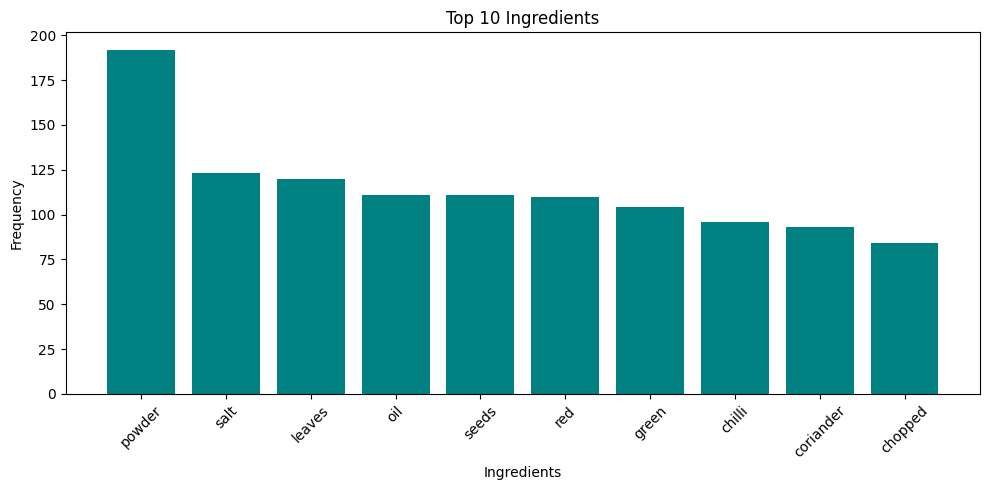

In [38]:
# plot the top frequent ingredients in training data
plot_top_items(train_ingredients, "Ingredients")


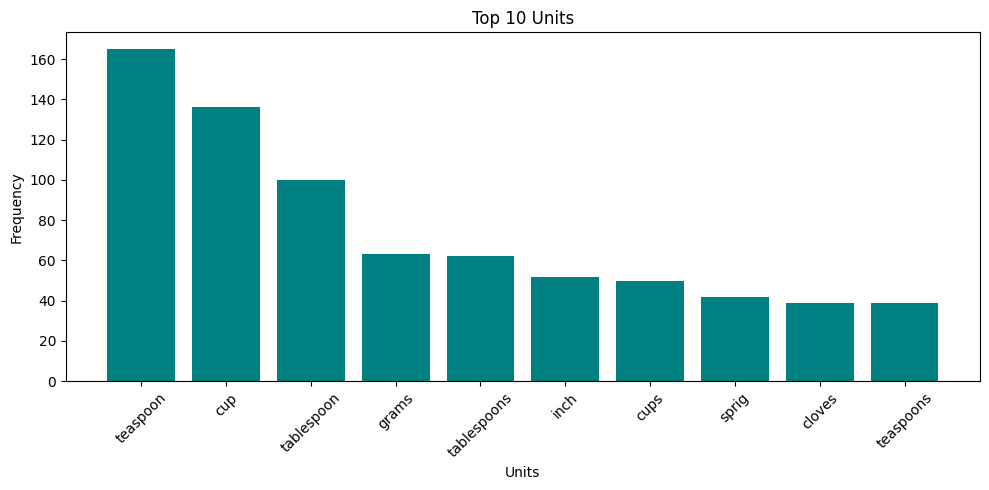

In [39]:
# plot the top frequent units in training data
plot_top_items(train_units, "Units")

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [40]:
import re

# define unit and quantity keywords along with quantity pattern
unit_keywords = {'drops', 'chopped', 'tsp', 'inches', 'inch', 'tablespoons', 'tablespoon', 'thin', 
                 'cup', 'grams', 'or', 'teaspoons', 'sprig', 'stalks', 'gms', 'cut', 'small', 
                 'fistful', 'tbsp', 'long', 'pinch', 'cups', 'finely', 'clove', 'spoon', 'teaspoon', 
                 'scoops', 'handful', 'cloves', 'wedges', 'liter', 'gram', 'sprigs', 
                 'thick', 'raw', 'ml', 'for', 'whole'}

quantity_keywords = {"half", "quarter", "third", "few", "dozen", "some", "one", "two", "three", "four", 
                     "five","six", "seven", "eight", "nine", "ten"}

quantity_pattern = re.compile(r'^\d+([-/.,]\d+)?$|^\d+/\d+$|^\d+[-]\d+/\d+$')


In [41]:
# load spaCy model
import spacy

# Load English model (make sure you've run: python -m spacy download en_core_web_sm)
nlp = spacy.load("en_core_web_sm")


##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [42]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions
def word2features(sent, i):
    token = sent[i]
    text = token.text
    text_lower = text.lower()

    features = {
        # --- Core Features ---
        'bias': 1.0,
        'token': text_lower,
        'lemma': token.lemma_.lower(),
        'pos_tag': token.pos_,
        'tag': token.tag_,
        'dep': token.dep_,
        'shape': token.shape_,
        'is_stop': token.is_stop,
        'is_digit': text.isdigit(),
        'has_digit': any(char.isdigit() for char in text),
        'has_alpha': any(char.isalpha() for char in text),
        'hyphenated': '-' in text,
        'slash_present': '/' in text,
        'is_title': token.is_title,
        'is_upper': token.is_upper,
        'is_punct': token.is_punct,

        # --- Improved Quantity and Unit Detection ---
        'is_quantity': text_lower in quantity_keywords or bool(quantity_pattern.match(text)),
        'is_unit': text_lower in unit_keywords,
        'is_numeric': text.isdigit() or bool(quantity_pattern.match(text)),
        'is_fraction': '/' in text and text.replace('/', '').isdigit(),
        'is_decimal': '.' in text and text.replace('.', '', 1).isdigit(),
        'preceding_word': sent[i - 1].text if i > 0 else '',
        'following_word': sent[i + 1].text if i < len(sent) - 1 else '',
    }

    # --- Contextual Features: Previous Token ---
    if i > 0:
        prev = sent[i - 1]
        prev_text = prev.text.lower()
        features.update({
            'prev_token': prev_text,
            'prev_is_quantity': prev_text in quantity_keywords or bool(quantity_pattern.match(prev_text)),
            'prev_is_digit': prev_text.isdigit(),
        })
    else:
        features['BOS'] = True

    # --- Contextual Features: Next Token ---
    if i < len(sent) - 1:
        next_ = sent[i + 1]
        next_text = next_.text.lower()
        features.update({
            'next_token': next_text,
            'next_is_unit': next_text in unit_keywords,
            'next_is_ingredient': next_text not in unit_keywords and next_text not in quantity_keywords,
        })
    else:
        features['EOS'] = True

    return features


### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [43]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]


### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [44]:
train_df['spacy_doc'] = train_df['input_tokens'].apply(lambda tokens: nlp(" ".join(tokens)))
val_df['spacy_doc'] = val_df['input_tokens'].apply(lambda tokens: nlp(" ".join(tokens)))

In [45]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features
X_train_features = [sent2features(doc) for doc in train_df['spacy_doc']]
X_val_features = [sent2features(doc) for doc in val_df['spacy_doc']]

# Display lengths
print("Length of X_train_features:", len(X_train_features))
print("Length of X_val_features:", len(X_val_features))


Length of X_train_features: 196
Length of X_val_features: 84


##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [46]:
# Convert labels into list as y_train_labels and y_val_labels
y_train_labels = train_df['pos_tokens'].tolist()
y_val_labels = val_df['pos_tokens'].tolist()


##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [47]:
# print the length of train features and labels
print("Length of X_train_features:", len(X_train_features))
print("Length of X_val_features:", len(X_val_features))


Length of X_train_features: 196
Length of X_val_features: 84


In [48]:
# print the length of validation features and labels
print("Length of y_train_labels:", len(y_train_labels))
print("Length of y_val_labels:", len(y_val_labels))


Length of y_train_labels: 196
Length of y_val_labels: 84


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [49]:
# Flatten labels in y_train
def flatten_list(nested_list):
    flattened_list = []
    for sublist in nested_list:
        for item in sublist:
            flattened_list.append(item)
    return flattened_list

# Flatten the training labels
y_train_flat = flatten_list(y_train_labels)

# Confirm result
print("Length of flattened y_train_labels:", len(y_train_flat))
print("First 20 flattened labels:", y_train_flat[:20])


Length of flattened y_train_labels: 7114
First 20 flattened labels: ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'unit', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'unit']


##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [50]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts
label_counts = Counter(y_train_flat)
total_samples = sum(label_counts.values())
print("Label Counts:")
for label, count in label_counts.items():
    print(f"  {label}: {count}")
print(f"\nTotal Samples (tokens with labels): {total_samples}")

Label Counts:
  quantity: 980
  unit: 811
  ingredient: 5323

Total Samples (tokens with labels): 7114


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [51]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts
class_weights = {
    label: total_samples / count
    for label, count in label_counts.items()
}

In [52]:
# penalise ingredient label
penalized_class_weights = class_weights.copy()
penalty_factor = 0.5
penalized_class_weights['ingredient'] *= penalty_factor


##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [53]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)
def extract_features_with_class_weights_old(df, dataset_name="Training"):

    print(f"\nExtracting features for {dataset_name} dataset...")

    features = [sent2features(doc) for doc in df['spacy_doc']]
    
    print(f"Extracted features from {len(features)} sentences in {dataset_name} set.")
    return features


In [54]:
def extract_features_with_class_weights(X, y, penalized_class_weights):
    weighted_features = []

    for sent_tokens, sent_labels in zip(X, y):
        features = []

        for i, token in enumerate(sent_tokens):
            token_features = word2features(sent_tokens, i)

            # Get the corresponding label for this token
            label = sent_labels[i] if i < len(sent_labels) else 'O'

            # Apply weight from class weights dictionary
            token_features['class_weight'] = penalized_class_weights.get(label, 1.0)

            features.append(token_features)

        weighted_features.append(features)

    return weighted_features


In [55]:
%xmode Plain

Exception reporting mode: Plain


##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [56]:
# Apply manually computed class weights
X_train_weighted_features = extract_features_with_class_weights(train_df['spacy_doc'].tolist(), train_df['pos_tokens'].tolist(), penalized_class_weights)

X_val_weighted_features = extract_features_with_class_weights( val_df['spacy_doc'].tolist(), val_df['pos_tokens'].tolist(), penalized_class_weights)

In [57]:
for i in range(len(X_train_weighted_features)):
    print(len(X_train_weighted_features[i]), end=" ")
print("\n")


31 41 27 23 12 50 32 32 26 25 22 44 37 34 53 18 86 30 29 29 53 32 30 39 31 39 45 23 42 35 23 43 39 41 52 28 60 46 48 29 36 17 29 54 33 50 28 45 54 47 33 30 88 22 22 76 45 30 13 32 32 22 30 38 60 31 30 36 31 28 35 38 20 38 38 44 23 52 25 20 55 17 38 28 32 21 28 30 45 31 41 52 22 29 45 25 44 29 70 42 36 28 50 32 44 29 71 46 30 19 49 27 24 23 40 11 23 23 18 48 20 35 61 31 57 46 23 47 32 38 43 55 31 27 20 18 28 46 37 41 55 47 35 30 94 41 49 22 25 39 29 48 34 33 42 43 63 28 30 16 35 95 51 34 59 38 36 73 31 37 25 32 17 34 28 8 15 43 33 48 50 33 97 47 31 51 25 64 37 34 41 26 46 23 41 39 



In [58]:
for i in range(len(y_train_labels)):
    print(len(y_train_labels[i]), end=" ")
print("\n")

31 41 25 21 12 48 32 32 26 25 22 42 37 34 47 18 84 30 29 29 51 32 30 35 31 37 43 23 42 35 23 43 39 41 52 28 54 46 46 29 34 17 29 46 33 50 28 45 54 47 33 30 67 22 22 72 45 30 13 32 32 22 28 38 60 31 30 36 31 28 35 38 20 38 38 42 23 50 23 20 55 17 38 28 32 21 28 30 45 31 41 52 22 29 45 25 44 29 70 40 36 24 50 30 38 29 71 44 30 19 49 25 24 23 40 11 23 23 18 44 20 35 61 31 53 46 23 47 32 34 39 55 31 27 20 18 28 46 37 41 55 45 35 28 68 41 49 22 25 35 29 48 34 33 42 41 63 28 30 16 35 83 51 34 57 38 36 73 29 37 25 32 17 32 26 8 15 43 33 42 50 33 93 43 29 51 25 60 37 34 41 24 44 23 41 39 



In [59]:
# There is some difference in the number of elements in X and y which causes CRF.fit to fail. The align_features_and_lables function below pads with label 'O' to make them equal
def align_features_and_labels(X, y, pad_label='O'):
    """
    Aligns feature and label sequences by padding label sequences
    if they are shorter than feature sequences.
    """
    corrected_X = []
    corrected_y = []

    for features, labels in zip(X, y):
        len_f = len(features)
        len_l = len(labels)

        if len_f > len_l:
            # Pad label sequence with dummy tag
            labels = labels + [pad_label] * (len_f - len_l)
        elif len_f < len_l:
            # Trim label sequence if it's longer (unexpected but handled)
            labels = labels[:len_f]

        corrected_X.append(features)
        corrected_y.append(labels)

    return corrected_X, corrected_y


In [60]:
X_train_weighted_features_aligned, y_train_labels_aligned = align_features_and_labels(
    X_train_weighted_features, y_train_labels
)


In [61]:
for i in range(len(y_train_labels_aligned)):
    print(len(y_train_labels_aligned[i]), end=" ")
print("\n")

31 41 27 23 12 50 32 32 26 25 22 44 37 34 53 18 86 30 29 29 53 32 30 39 31 39 45 23 42 35 23 43 39 41 52 28 60 46 48 29 36 17 29 54 33 50 28 45 54 47 33 30 88 22 22 76 45 30 13 32 32 22 30 38 60 31 30 36 31 28 35 38 20 38 38 44 23 52 25 20 55 17 38 28 32 21 28 30 45 31 41 52 22 29 45 25 44 29 70 42 36 28 50 32 44 29 71 46 30 19 49 27 24 23 40 11 23 23 18 48 20 35 61 31 57 46 23 47 32 38 43 55 31 27 20 18 28 46 37 41 55 47 35 30 94 41 49 22 25 39 29 48 34 33 42 43 63 28 30 16 35 95 51 34 59 38 36 73 31 37 25 32 17 34 28 8 15 43 33 48 50 33 97 47 31 51 25 64 37 34 41 26 46 23 41 39 



## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [62]:
# initialise CRF model with the specified hyperparameters and use weight_dict

# train the CRF model with the weighted training data


from sklearn_crfsuite import CRF

# Initialize CRF with specified hyperparameters and weights
crf = CRF(
    algorithm='lbfgs',             # Optimizer
    c1=0.1,                        # L1 regularization
    c2=0.1,                        # L2 regularization
    max_iterations=100,           # Max training iterations
    all_possible_transitions=True,  # Allow unseen transitions
)
# Train CRF model on weighted features and labels
print("Training CRF model...")
crf.fit(X_train_weighted_features_aligned, y_train_labels_aligned)
print("CRF training complete.")

Training CRF model...
CRF training complete.


### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [63]:
# evaluate on the training dataset
y_train_pred = crf.predict(X_train_weighted_features_aligned)


In [64]:
# specify the flat classification report by using training data for evaluation
from sklearn_crfsuite import metrics

# Create a flat list of true and predicted labels
y_train_true_flat = [label for seq in y_train_labels_aligned for label in seq]
y_train_pred_flat = [label for seq in y_train_pred for label in seq]

# Generate classification report
report = metrics.flat_classification_report(
    y_train_labels_aligned, y_train_pred,
    digits=3
)

print("CRF Training Set Evaluation Report:")
print(report)


CRF Training Set Evaluation Report:
              precision    recall  f1-score   support

           O      1.000     1.000     1.000       191
  ingredient      1.000     1.000     1.000      5323
    quantity      0.998     1.000     0.999       980
        unit      1.000     0.998     0.999       811

    accuracy                          1.000      7305
   macro avg      0.999     0.999     0.999      7305
weighted avg      1.000     1.000     1.000      7305



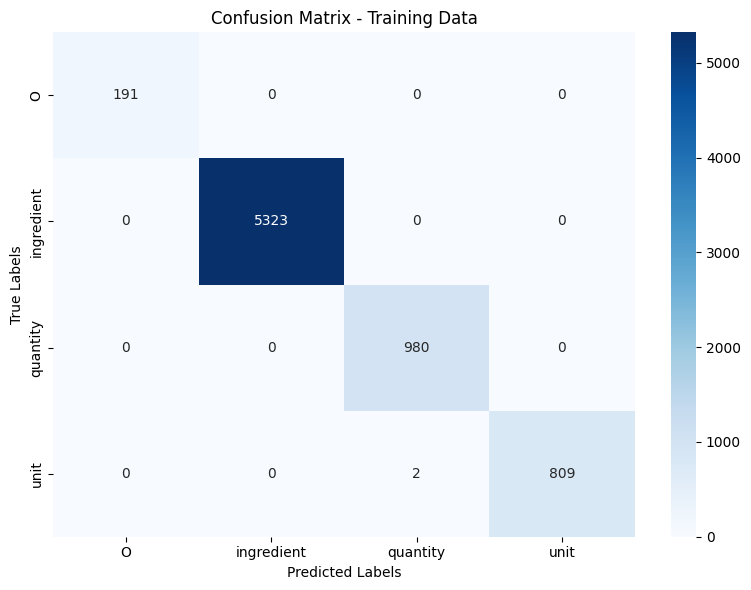

In [65]:
# create a confusion matrix on training datset
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Flatten the true and predicted label sequences
y_train_true_flat = [label for seq in y_train_labels_aligned for label in seq]
y_train_pred_flat = [label for seq in y_train_pred for label in seq]

# Step 2: Get unique sorted labels from the CRF model
labels = sorted(crf.classes_)

# Step 3: Create the confusion matrix
cm = confusion_matrix(y_train_true_flat, y_train_pred_flat, labels=labels)

# Step 4: Plot using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.title("Confusion Matrix - Training Data")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()


### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [66]:
# dump the model using joblib as crf_model.pkl
import joblib

# Save the trained CRF model to disk
joblib.dump(crf, 'ner_recipe_crf_model.pkl')


['ner_recipe_crf_model.pkl']

## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [67]:
X_val_weighted_features_aligned, y_val_labels_aligned = align_features_and_labels(X_val_weighted_features, y_val_labels)

In [68]:
# predict the crf model on validation dataset
# Predict labels for validation dataset
y_val_pred = crf.predict(X_val_weighted_features_aligned)


In [69]:
# specify flat classification report
from sklearn_crfsuite import metrics

# Generate classification report
val_classification_report = metrics.flat_classification_report(
    y_true=y_val_labels_aligned,
    y_pred=y_val_pred,
    labels=crf.classes_,   # Use only classes seen by CRF
    digits=3
)

# Display report
print("CRF Validation Data Classification Report:\n")
print(val_classification_report)


CRF Validation Data Classification Report:

              precision    recall  f1-score   support

    quantity      0.971     0.983     0.977       411
        unit      0.986     0.966     0.976       358
  ingredient      0.995     1.000     0.997      2107
           O      0.966     0.896     0.930        96

    accuracy                          0.990      2972
   macro avg      0.980     0.961     0.970      2972
weighted avg      0.990     0.990     0.990      2972



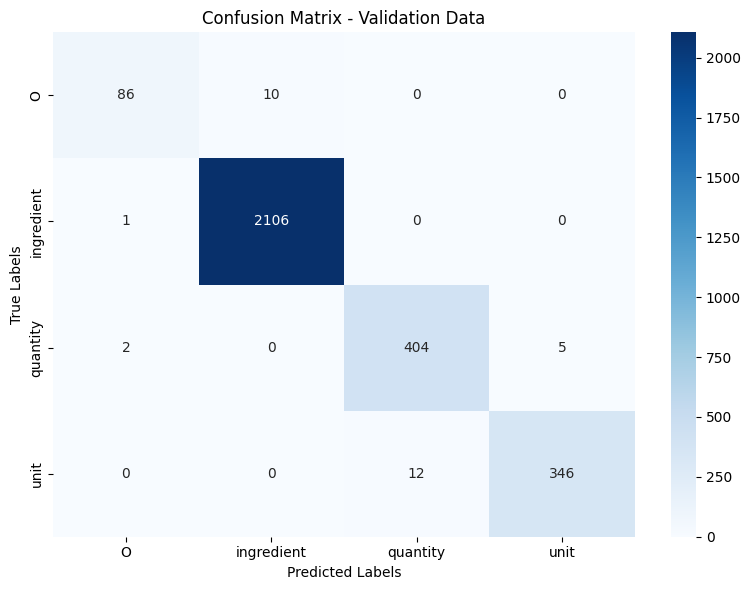

In [70]:
# create a confusion matrix on validation dataset
y_val_true_flat = [label for seq in y_val_labels_aligned for label in seq]
y_val_pred_flat = [label for seq in y_val_pred for label in seq]

# Step 2: Get unique sorted labels from the CRF model
labels = sorted(crf.classes_)

# Step 3: Create the confusion matrix
cm = confusion_matrix(y_val_true_flat, y_val_pred_flat, labels=labels)

# Step 4: Plot using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.title("Confusion Matrix - Validation Data")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()

## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [71]:
# iterate and collect Error Information

error_data = []

# Step 1: Iterate through each sentence in the validation set
for sent_idx, (tokens, true_labels, pred_labels) in enumerate(zip(X_val_features, y_val_labels_aligned, y_val_pred)):
    for i, (token_feats, true_label, pred_label) in enumerate(zip(tokens, true_labels, pred_labels)):
        if true_label != pred_label:
            error_entry = {
                'sentence_index': sent_idx,
                'token_index': i,
                'token': token_feats['token'],
                'true_label': true_label,
                'pred_label': pred_label,
                'prev_token': tokens[i - 1]['token'] if i > 0 else 'BOS',
                'next_token': tokens[i + 1]['token'] if i < len(tokens) - 1 else 'EOS',
                'true_label_weight': penalized_class_weights.get(true_label, 1.0),
                'pred_label_weight': penalized_class_weights.get(pred_label, 1.0),
                'is_stop': token_feats['is_stop'],
                'is_digit': token_feats['is_digit'],
                'is_quantity': token_feats['is_quantity'],
                'is_unit': token_feats['is_unit'],
                'pos_tag': token_feats['pos_tag']
            }
            error_data.append(error_entry)
            
print(f"Total Misclassifications in Validation Set: {len(error_data)}")

Total Misclassifications in Validation Set: 30


##### **9.1.2** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [72]:
# Create DataFrame and Print Overall Accuracy
error_df = pd.DataFrame(error_data)

##### **9.1.3** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [73]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context

from collections import Counter
import pandas as pd

# Step 1: Count total true labels and error counts
true_label_counts = Counter([label for seq in y_val_labels_aligned for label in seq])
error_label_counts = error_df['true_label'].value_counts().to_dict()

# Step 2: Prepare label-wise error analysis
label_analysis = []

all_labels = sorted(set(true_label_counts.keys()) | set(error_label_counts.keys()))

for label in all_labels:
    total = true_label_counts.get(label, 0)
    errors = error_label_counts.get(label, 0)
    correct = total - errors
    accuracy = correct / total if total > 0 else 0.0
    weight = penalized_class_weights.get(label, 1.0)
    
    label_analysis.append({
        'Label': label,
        'Total': total,
        'Errors': errors,
        'Accuracy': round(accuracy, 3),
        'Class Weight': round(weight, 3)
    })

# Convert to DataFrame
label_analysis_df = pd.DataFrame(label_analysis).sort_values(by='Errors', ascending=False)

# Display label-wise error analysis
print("Error Analysis by Label:")
display(label_analysis_df)



Error Analysis by Label:


Label  Total  Errors  Accuracy  Class Weight
3        unit    358      12     0.966         8.772
0           O     96      10     0.896         1.000
2    quantity    411       7     0.983         7.259
1  ingredient   2107       1     1.000         0.668

### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




 <font color = red>The validation results are excellent but there are some unknown labels which are displayed as 'O'. This seems to be a result of some mismatch in the data due to which I had to add padding with 'O' label</font>

## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.